<a href="https://colab.research.google.com/github/syedshubha/QNET25_Shubha/blob/main/QD_Error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qutip
%pip install --quiet qiskit
%pip install --quiet qiskit-aer
%pip install --quiet pylatexenc

In [2]:
from qutip import *

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.linalg import logm, sqrtm
import warnings

In [3]:
zero = basis(2, 0)
one = basis(2, 1)

bell_state = (tensor(zero, zero) + tensor(one, one)).unit()
I = qeye(2)
rho = ket2dm(bell_state)  # Convert to density matrix

In [4]:
def von_neumann_entropy(rho):
    eigenvalues = rho.eigenenergies()
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    eigenvalues = eigenvalues[eigenvalues > 0]  # Ignore zero eigenvalues
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    return -np.sum(eigenvalues * np.log2(eigenvalues))

In [5]:
# Quantum Mutual Information
def quantum_mutual_information(rho):
    rho_A = rho.ptrace(0)  # Partial trace over B
    rho_B = rho.ptrace(1)  # Partial trace over A
    return von_neumann_entropy(rho_A) + von_neumann_entropy(rho_B) - von_neumann_entropy(rho)

# Classical Mutual Information
def classical_mutual_information(rho):
    rho_A = rho.ptrace(0)  # Partial trace over B
    rho_B = rho.ptrace(1)  # Partial trace over A
    def classical_corr(theta_phi):
        cond_entropy_B = 0
        theta, phi = theta_phi
        # Define measurement operator directly in QuTiP
        proj_0 = Qobj([[np.cos(theta / 2) ** 2, np.cos(theta / 2) * np.sin(theta / 2) * np.exp(-1j * phi)],
                       [np.cos(theta / 2) * np.sin(theta / 2) * np.exp(1j * phi), np.sin(theta / 2)**2]])
        proj_1 = Qobj([[np.sin(theta / 2) ** 2, -np.cos(theta / 2) * np.sin(theta / 2) * np.exp(-1j * phi)],
                       [-np.cos(theta / 2) * np.sin(theta / 2) * np.exp(1j * phi), np.cos(theta / 2)**2]])

        # Extend projectors to two-qubit space
        proj_0 = tensor(proj_0, qeye(2))
        proj_1 = tensor(proj_1, qeye(2))

        for proj in [proj_0, proj_1]:
            p_k = (proj * rho * proj.dag()).tr()
            if p_k > 1e-10:
                rho_post = (proj * rho * proj.dag()) / p_k
                rho_B_k = rho_post.ptrace(1)  # Partial trace over first qubit
                cond_entropy_B += p_k * von_neumann_entropy(rho_B_k)

        return -(von_neumann_entropy(rho_A) - cond_entropy_B)  # Negative for minimization
    result = minimize(classical_corr, [0, 0], bounds=[(0, np.pi), (0, 2 * np.pi)], method='Nelder-Mead')
    return -result.fun
# Quantum Discord
def quantum_discord(rho):
    return quantum_mutual_information(rho) - classical_mutual_information(rho)

In [6]:
# Concurrence for two-qubit state
def concurrence(rho):
    Y = Qobj([[0, -1j], [1j, 0]])  # Pauli Y
    R = rho * tensor(Y, Y) * rho.conj() * tensor(Y, Y)
    eigenvalues = np.sqrt(np.real(np.sort(R.eigenenergies())[::-1]))
    return max(0, eigenvalues[0] - sum(eigenvalues[1:]))

# Entanglement of Formation
def entanglement_of_formation(rho):
    C = concurrence(rho)
    if C == 0:
        return 0
    h = lambda x: -x * np.log2(x) - (1 - x) * np.log2(1 - x) if x > 0 else 0
    return h((1 + np.sqrt(1 - C**2)) / 2)

In [7]:
def cartesian(A, n):
  if n==1:
    return [[a] for a in A]
  else:
    result = []
    for a in A:
      for p in cartesian(A, n-1):
        result.append([a] + p)
    return result

# Extending Kraus
def tensoring(n,lst):
  ins = cartesian(lst, n)
  ch = []
  for i in ins:
    for j in range(n):
      if j == 0:
        p = i[j]
      else:
        p = tensor(p,i[j])
    ch.append(p)
  return ch

# Channel
def evolve(rho,lst):
  DM = 0*rho
  for T in lst:
    DM = T*rho*T.dag() + DM
  return DM

In [8]:
def noise_channel(rho, p, q, n):
    # Amplitude damping operators
    E0_amp = Qobj([[1, 0], [0, np.sqrt(1 - p)]])
    E1_amp = Qobj([[0, np.sqrt(p)], [0, 0]])
    # Phase damping operators
    E0_phase = Qobj([[np.sqrt(q), 0], [0, 0]])
    E1_phase = Qobj([[0, 0], [0, np.sqrt(q)]])
    E2_phase = Qobj([[np.sqrt(1-q), 0], [0, np.sqrt(1-q)]])

    #Extending for two qubit systems
    AD = tensoring(n, [E0_amp, E1_amp])
    PD = tensoring(n, [E0_phase, E1_phase, E2_phase])

    # Evolve the channel
    rho_after_amp = evolve(rho, AD)
    rho_final1 = evolve(rho_after_amp, PD)

    rho_after_phase = evolve(rho, PD)
    rho_final2= evolve(rho_after_phase, AD)

    rho_final = (rho_final1 + rho_final2)/2
    return rho_final

In [9]:
p = np.linspace(0.01, 1, 100)
q = np.linspace(0.1, 1, 10)
rho = ket2dm(bell_state)

discord_list = [[] for i in range(len(q))]
eof_list = [[] for i in range(len(q))]
fid_list = [[] for i in range(len(q))]

for i in range(len(q)):
  for j in range(len(p)):
    rho_final = noise_channel(rho, p[j], q[i], 2)
    discord = quantum_discord(rho_final)
    eof = entanglement_of_formation(rho_final)
    fid = metrics.fidelity(rho, rho_final)
    fid_list[i].append(fid**2)
    discord_list[i].append(discord)
    eof_list[i].append(eof)

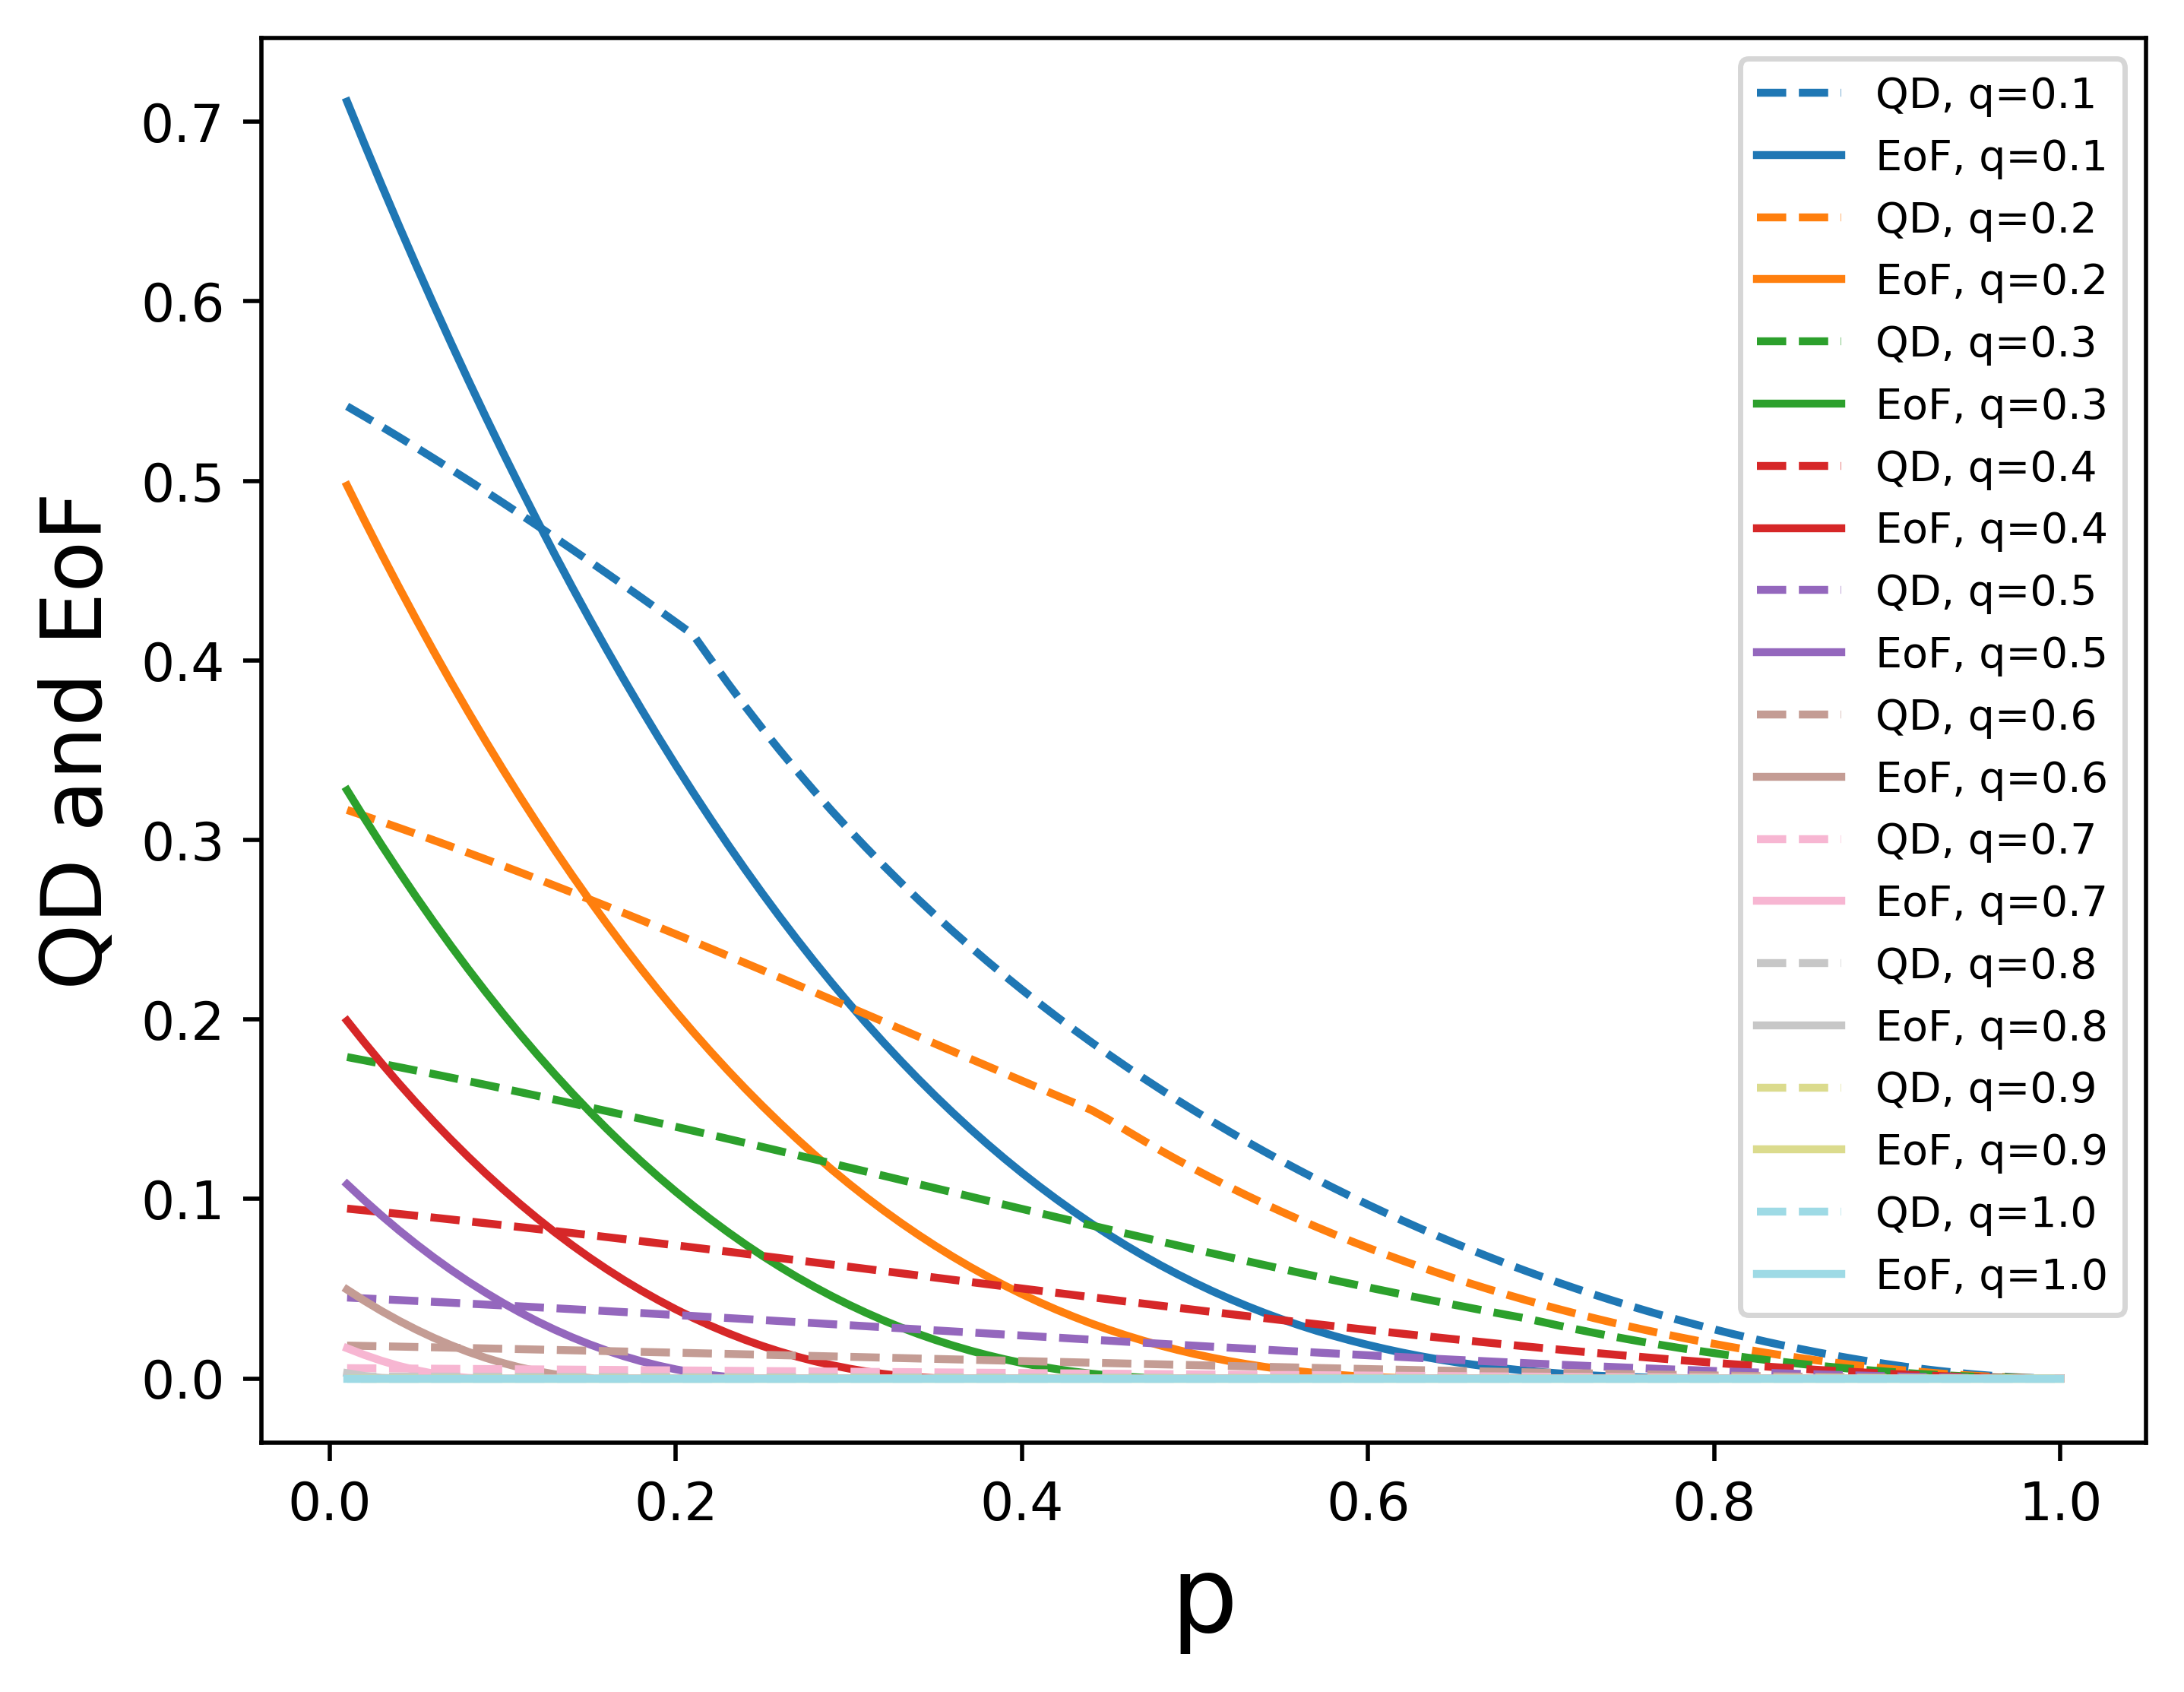

In [10]:
colors = plt.cm.tab20(np.linspace(0, 1, 10))
plt.figure(dpi=500)
for i in range(10):
  plt.plot(p, discord_list[i], label=f"QD, q={round(q[i],2)}", linestyle='--', color=colors[i])
  plt.plot(p, eof_list[i], label=f"EoF, q={round(q[i],2)}", color=colors[i])
plt.xlabel('p',fontsize=20)
plt.ylabel('QD and EoF',fontsize=16)
plt.legend(loc='upper right', fontsize=8)
plt.savefig('QDEoF.png', bbox_inches='tight')
plt.show()

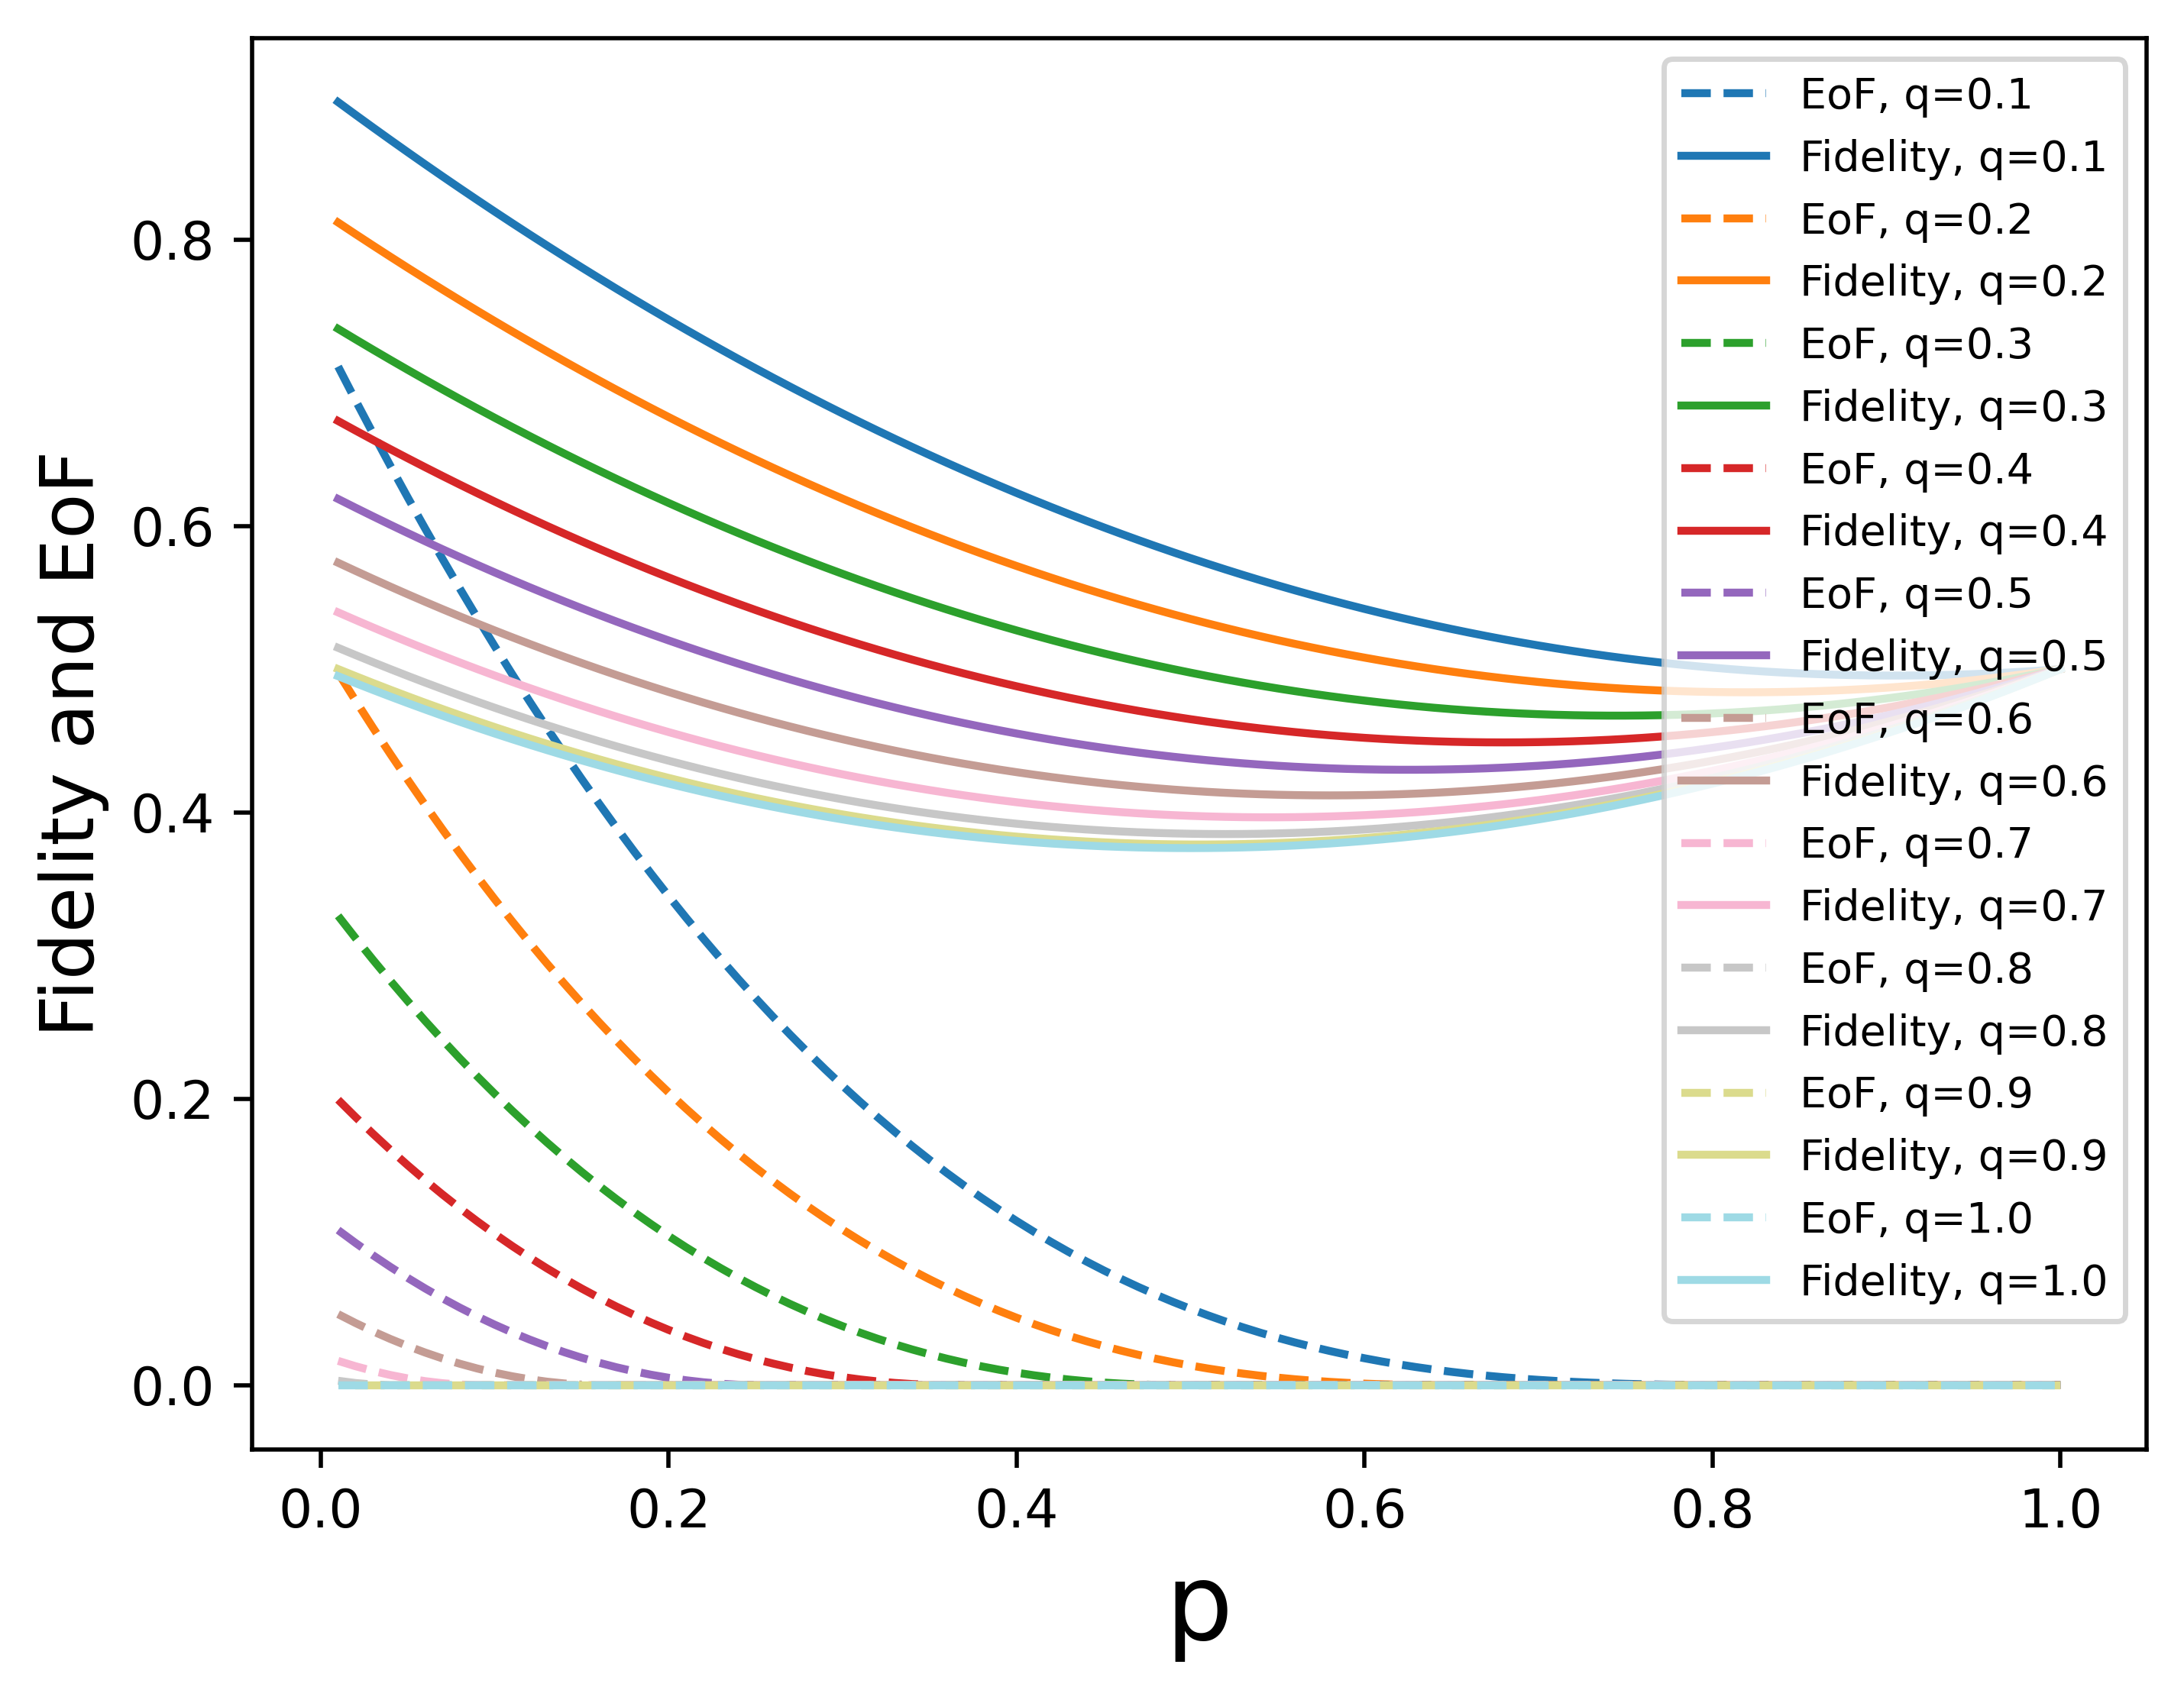

In [11]:
colors = plt.cm.tab20(np.linspace(0, 1, 10))
plt.figure(dpi=500)
for i in range(10):
  plt.plot(p, eof_list[i], label=f"EoF, q={round(q[i],2)}", linestyle='--', color=colors[i])
  plt.plot(p, fid_list[i], label=f"Fidelity, q={round(q[i],2)}", color=colors[i])
plt.xlabel('p',fontsize=20)
plt.ylabel('Fidelity and EoF',fontsize=14)
plt.legend(loc='upper right', fontsize=8)
plt.savefig('FidEoF.png', bbox_inches='tight')
plt.show()

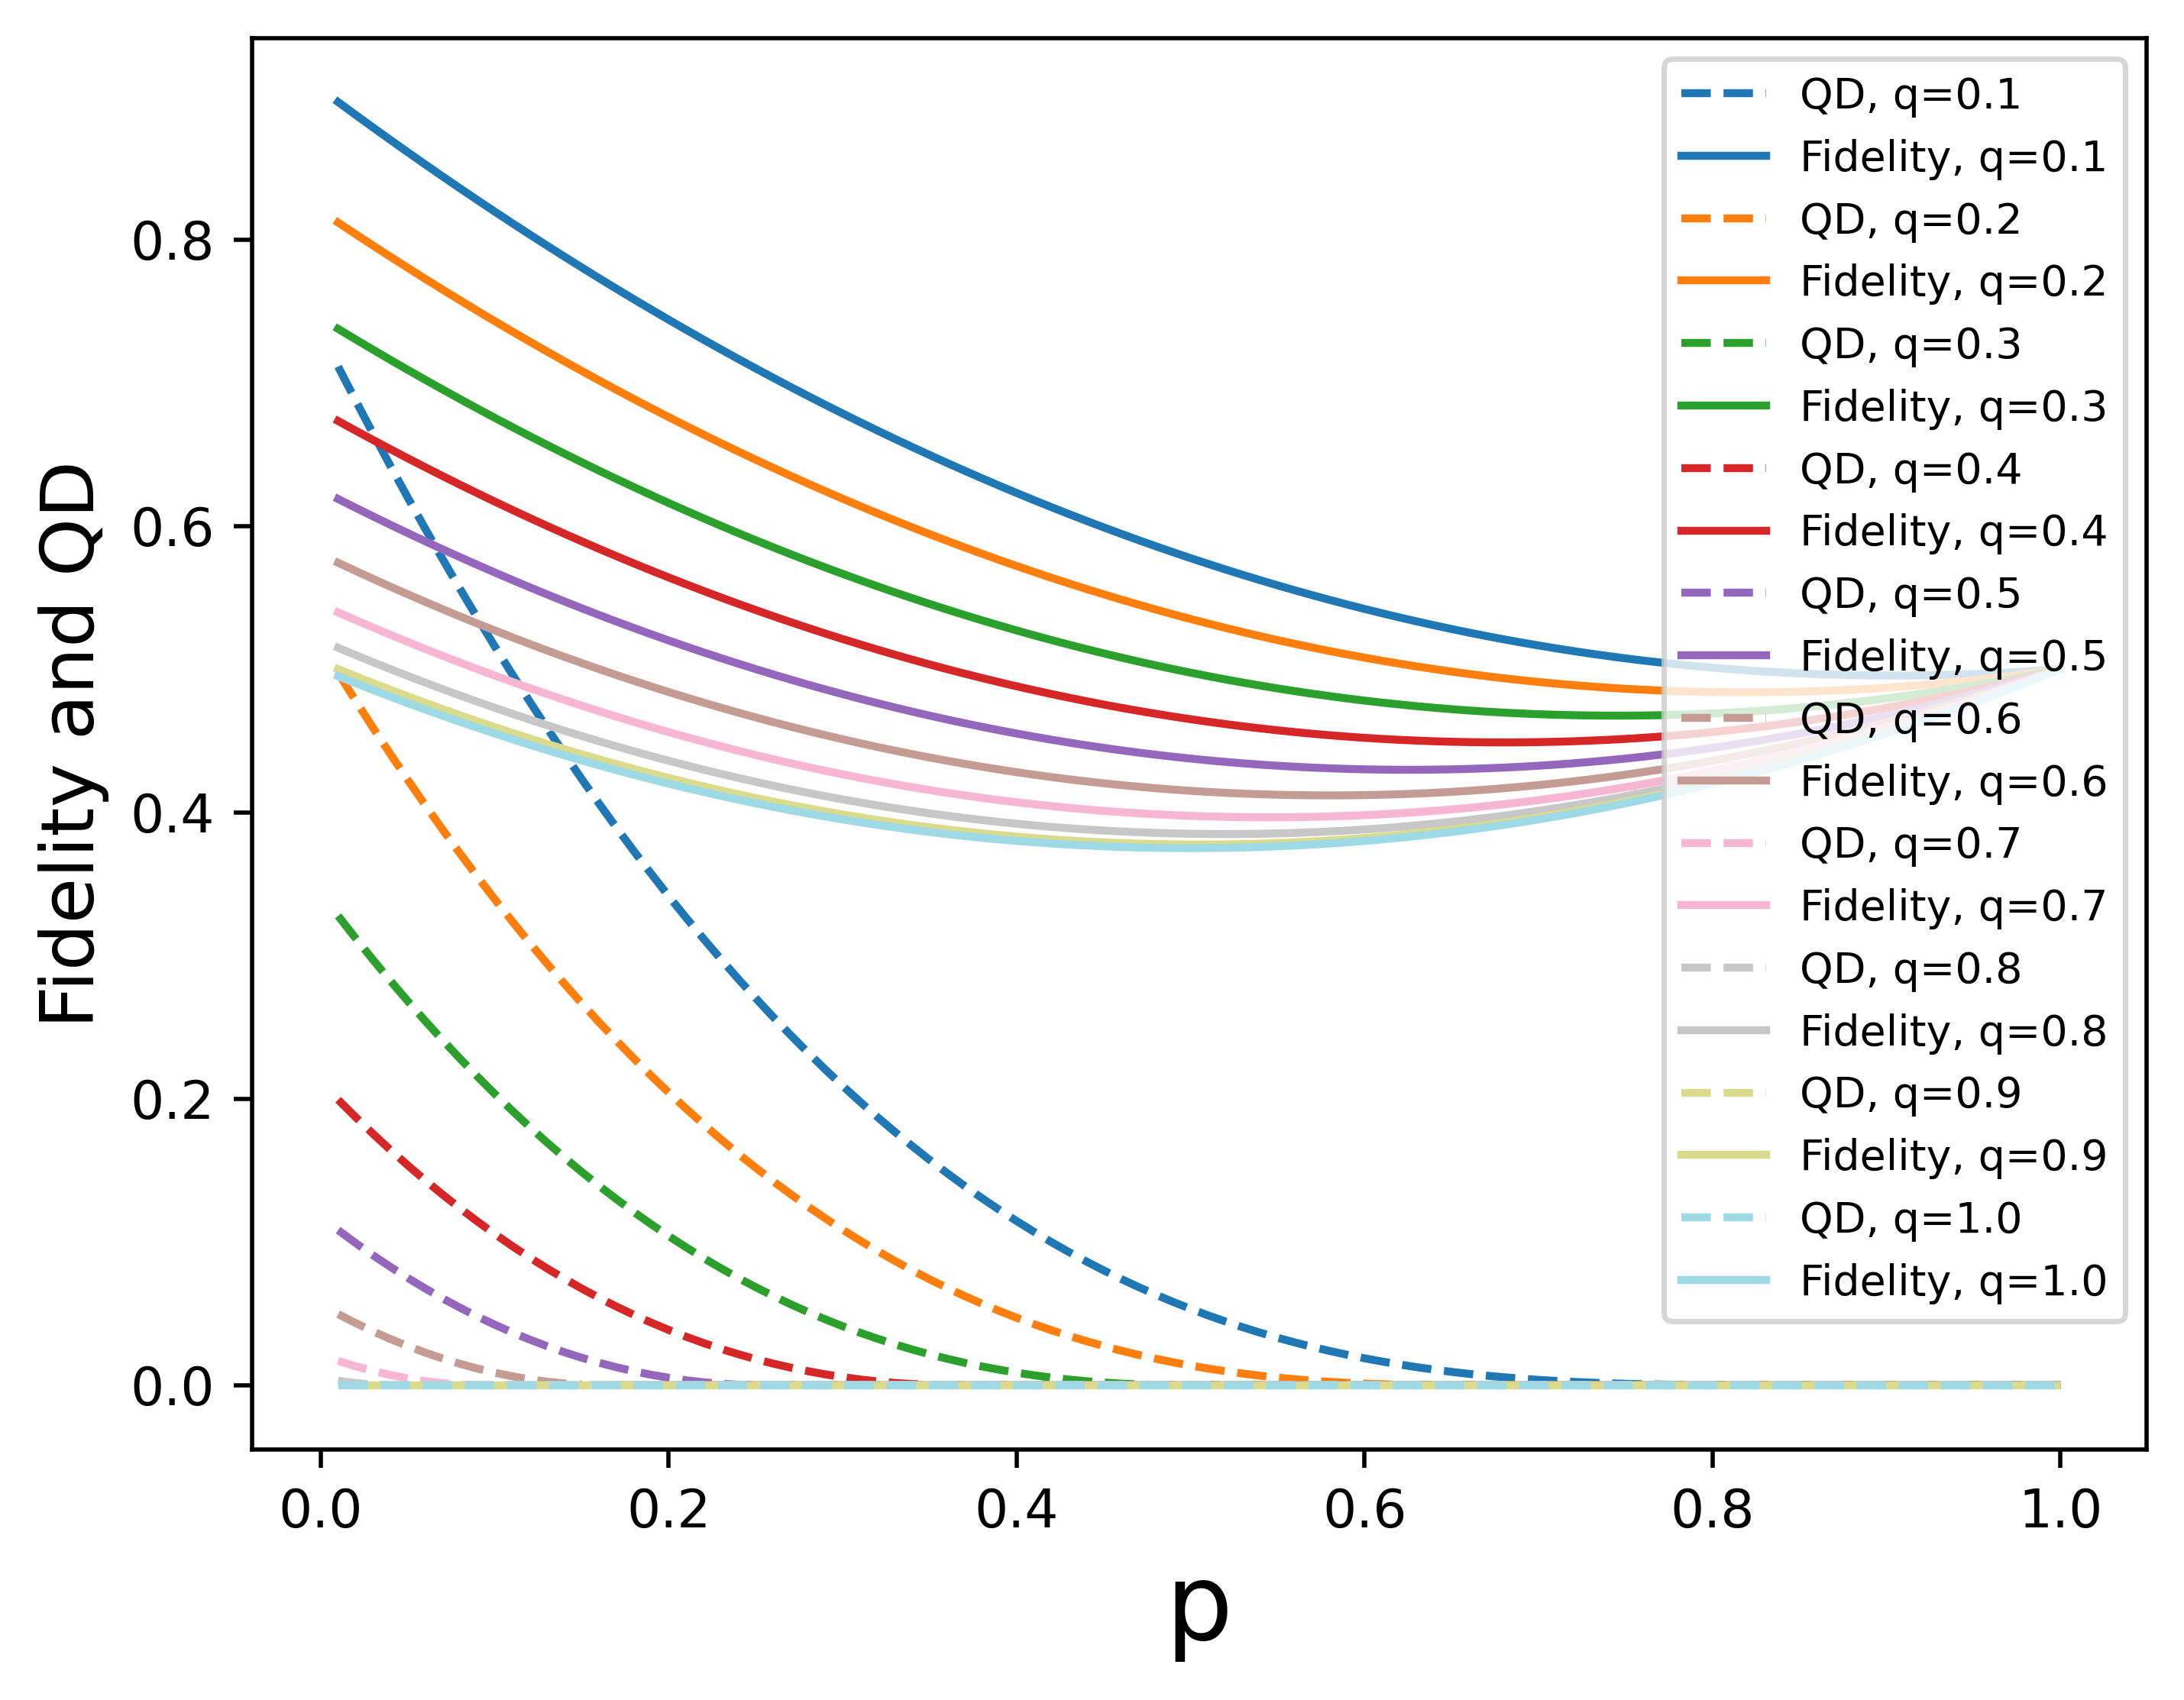

In [12]:
colors = plt.cm.tab20(np.linspace(0, 1, 10))
plt.figure(dpi=500)
for i in range(10):
  plt.plot(p, eof_list[i], label=f"QD, q={round(q[i],2)}", linestyle='--', color=colors[i])
  plt.plot(p, fid_list[i], label=f"Fidelity, q={round(q[i],2)}", color=colors[i])
plt.xlabel('p',fontsize=20)
plt.ylabel('Fidelity and QD',fontsize=14)
plt.legend(loc='upper right', fontsize=8)
plt.savefig('FidQD.png', bbox_inches='tight')
plt.show()

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from numpy import pi
theta = Parameter('θ')

def dejmps_purification(theta):
    Alice = QuantumRegister(2, 'Alice')
    Bob = QuantumRegister(2, 'Bob')

    cr = ClassicalRegister(2, 'c')

    qc = QuantumCircuit(Alice, Bob, cr)

    qc.h(Alice[0])
    qc.cx(Alice[0], Bob[0])

    qc.h(Alice[1])
    qc.cx(Alice[1], Bob[1])


    qc.ry(theta, Alice[0])
    qc.ry(theta, Bob[0])
    qc.ry(theta, Alice[1])
    qc.ry(theta, Bob[1])

    qc.cx(Alice[0], Alice[1])
    qc.cx(Bob[0], Bob[1])

    qc.measure(Alice[1], cr[0])
    qc.measure(Bob[1], cr[1])

    return qc



qc = dejmps_purification(theta)
qc.draw(output="mpl", initial_state=True).savefig('DeJmps.png', bbox_inches='tight',dpi=1000)

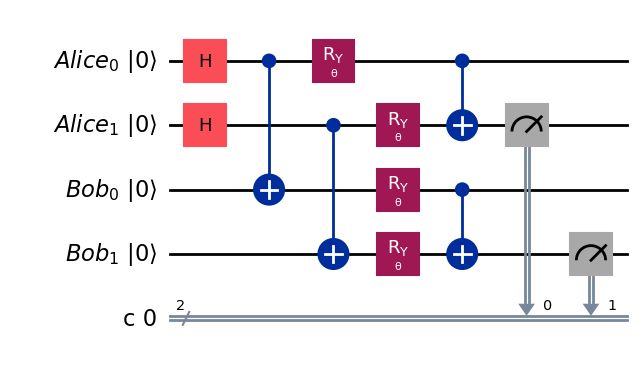

In [14]:
qc.draw(output="mpl", initial_state=True)